In [12]:
import torch
from google.colab import drive

torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

drive.mount('/content/drive')

Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Ucitavanje podataka je uradjeno pomocu AI alata.
import os

DATA_DIR = "/content/PlantVillage"

if not os.path.exists(DATA_DIR):
    print("Copying dataset...")
    !cp -r "/content/drive/MyDrive/PlantVillageDataset/Biljke/PlantVillage" "/content/PlantVillage"
    print("Copy finished.")
else:
    print("Dataset already exists. Skipping copy.")

Dataset already exists. Skipping copy.


In [14]:
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [16]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.49, 0.45, 0.4],
        std=[0.23, 0.3, 0.22]
    )
])

In [17]:
dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)

print("Total images:", len(dataset))
print("Classes:", len(dataset.classes))

Total images: 20638
Classes: 15


In [18]:
total_size = len(dataset)

train_size = int(0.7 * total_size)
val_size   = int(0.15 * total_size)
test_size  = total_size - train_size - val_size

generator = torch.Generator().manual_seed(42)

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

num_classes = len(dataset.classes)

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
          nn.Conv2d(3, 32, kernel_size=3, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.MaxPool2d(2),

          nn.Conv2d(32, 64, kernel_size=3, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(2),

          nn.Conv2d(64, 128, kernel_size=3, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(2),

          nn.Conv2d(128, 256, kernel_size=3, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.MaxPool2d(2)
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)        
        x = self.classifier(x)
        return x

model = CNN(num_classes=num_classes).to(device)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

In [21]:
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler=None, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (preds == labels).sum().item()

        train_acc = 100 * train_correct / train_total

        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        print(f"Epoch {epoch+1}: Train {train_acc:.2f}% | Val {val_acc:.2f}%")

        if scheduler:
            scheduler.step(val_acc)

In [22]:
print("Training...")

train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs=16)

Training...
Epoch 1: Train 48.34% | Val 58.93%
Epoch 2: Train 68.94% | Val 66.04%
Epoch 3: Train 76.53% | Val 79.68%
Epoch 4: Train 81.59% | Val 78.74%
Epoch 5: Train 84.56% | Val 88.30%
Epoch 6: Train 86.29% | Val 86.01%
Epoch 7: Train 87.75% | Val 88.21%
Epoch 8: Train 88.83% | Val 89.34%
Epoch 9: Train 89.49% | Val 90.37%
Epoch 10: Train 90.62% | Val 90.21%
Epoch 11: Train 91.08% | Val 89.34%
Epoch 12: Train 91.26% | Val 92.79%
Epoch 13: Train 92.31% | Val 90.53%
Epoch 14: Train 92.73% | Val 92.96%
Epoch 15: Train 92.98% | Val 90.50%
Epoch 16: Train 93.11% | Val 93.41%


Test Accuracy: 93.34840167904423
Test F1-score: 0.9328103493459289


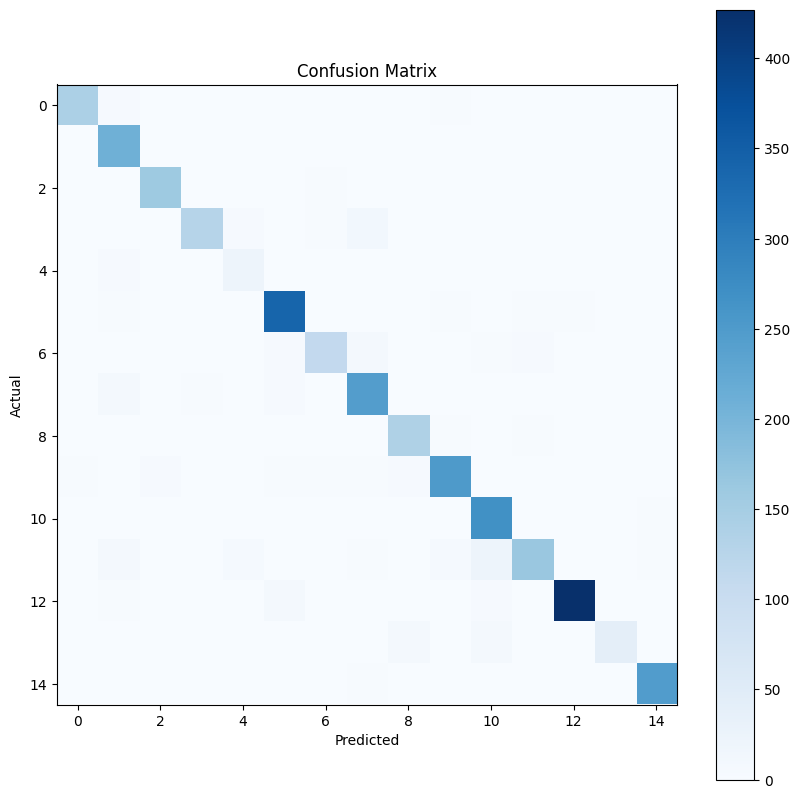

In [23]:
# Evaluacija modela je uradjena pomocu AI alata.
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = (all_preds == all_labels).mean() * 100
f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print("Test Accuracy:", accuracy)
print("Test F1-score:", f1)

plt.figure(figsize=(10, 10))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

In [24]:
# Cuvanje modela na drive-u je uradjeno pomocu AI
torch.save(model.state_dict(), "/content/drive/MyDrive/classic_cnn_plantvillage.pth")

import json
with open("/content/drive/MyDrive/classic_cnn_class_to_idx.json", "w") as f:
    json.dump(dataset.class_to_idx, f)

In [25]:
import shutil

TEST_DIR = "/content/drive/MyDrive/classic_cnn_PlantVillage_test"

os.makedirs(TEST_DIR, exist_ok=True)

for idx in test_dataset.indices:
    img_path, label = dataset.samples[idx]
    class_name = dataset.classes[label]

    class_dir = os.path.join(TEST_DIR, class_name)
    os.makedirs(class_dir, exist_ok=True)

    shutil.copy(img_path, class_dir)

print("Test images saved to Drive")

Test images saved to Drive
